In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
twilight = colormaps["twilight"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
twilight.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    ["/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(5)],  # Which sub-pixel position
    **kwargs,
)

files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")
files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



1
  TARGPROP: HD-41094
  FILTER: F380M
  NINTS: 1060
  NGROUPS: 11
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 3


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
import jax.numpy as np
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import PointFit

oversample = 4
optics = AMIOptics(radial_orders=4, oversize=1.1, oversample=oversample)
detector = LinearDetectorModel(oversample=oversample)
ramp_model = PolyNonLin(oversample=oversample)
read_model = ReadModel()

# Prep the model
fit = PointFit()
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, fit_one_on_fs=False)

# Add the binary parameters
model = AmigoModel(
    files, params, optics=optics, detector=detector, ramp=ramp_model, read=read_model
)

## Model and look at splodges, mask 

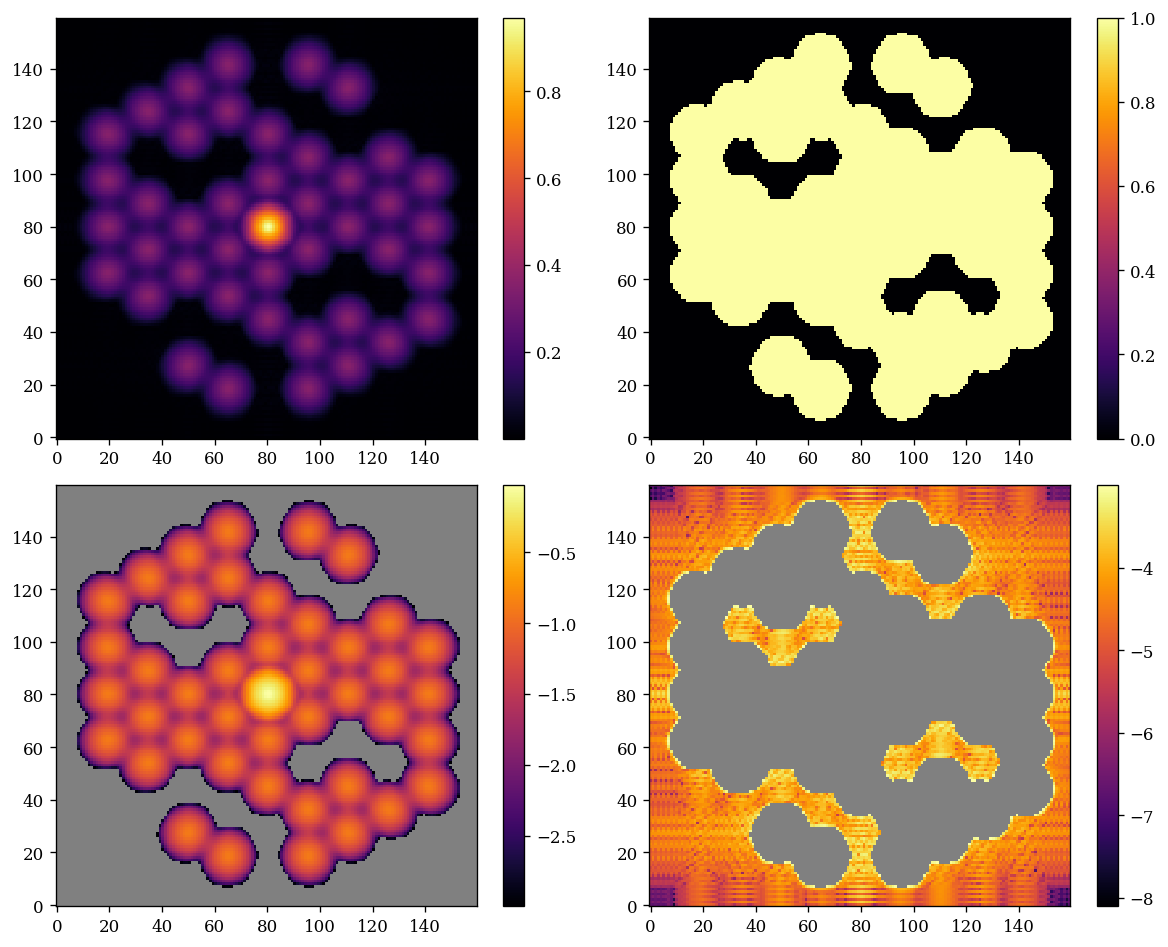

In [5]:
from jax import vmap
import interpax as ipx
import dLux.utils as dlu
from amigo.interferometry import to_uv, from_uv

# Create the splodges
uv_pad = 2
exp = exposures[0]
psf = fit.model_wfs(model, exp).psf.sum(0)
padded = dlu.resize(psf, uv_pad * len(psf))
npix_in = padded.shape[-1]

# Crop the splodges
npix_out = 160
full_splodges = to_uv(padded)
splodges = np.abs(dlu.resize(full_splodges, npix_out))

# Mask outside the OTF region - Shouldn't need to be done in practice
mask = splodges > 1e-3
inner = np.where(mask, splodges, np.nan)
outer = np.where(~mask, splodges, np.nan)

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(splodges ** 0.5)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(mask)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(np.log10(inner), cmap=inferno)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.log10(outer), cmap=inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

## Find control points (knots) to match visibility coordinates

187 control points


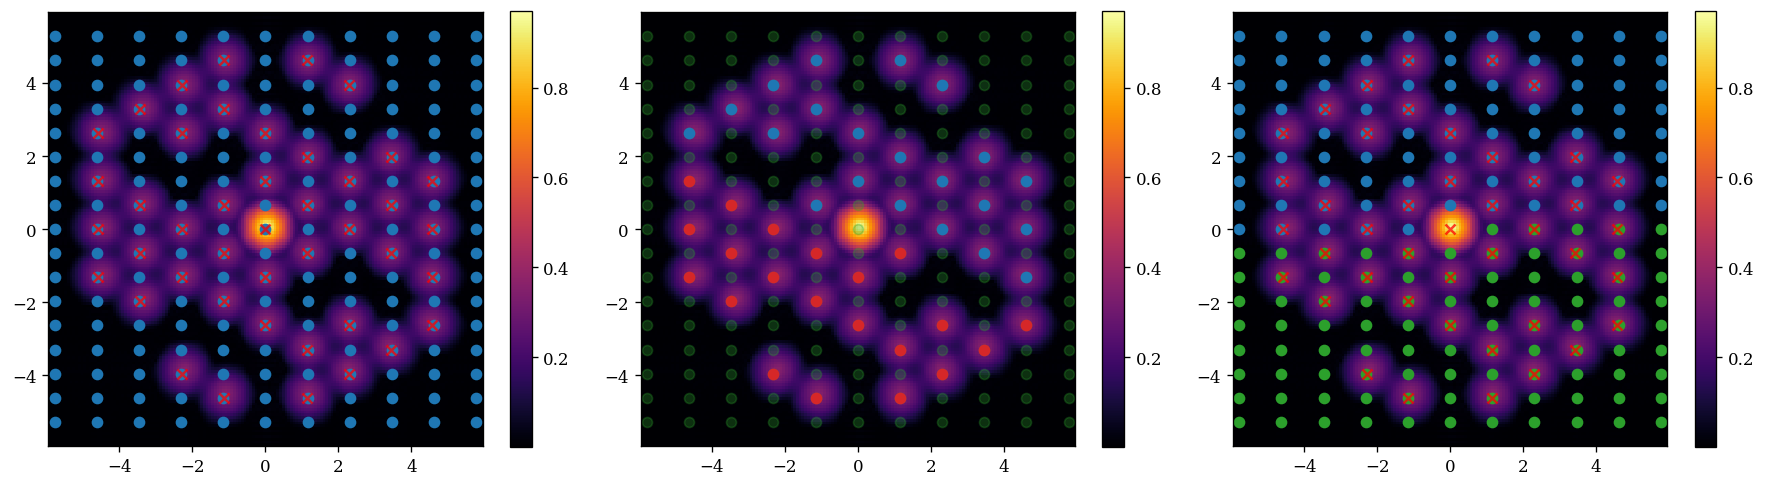

In [6]:
import jax.random as jr
from amigo.interferometry import get_baselines_and_inds, osamp_freqs


# Make interpolator of the visibilities on the OTF coordinates
cen_holes = optics.holes - optics.holes.mean(0)[None, :]
# cen_holes = optics.holes
hbls, inds = get_baselines_and_inds(cen_holes)
bls = np.concatenate([np.zeros((1, 2)), hbls, -hbls]).T

# Define number of control points and add padding to control outer behaviour
# TODO: Check padding is being applied correctly
x_pts, y_pts = 9, 15
pad_x, pad_y = 1, 2
nx, ny = x_pts + 2 * pad_x, y_pts + 2 * pad_x
dx, dy = 2 / (x_pts - 1), 2 / (y_pts - 1)
xs = bls.max() * np.linspace(-(1 + dx), 1 + dx, x_pts + 2)
ys = bls.max() * np.linspace(-(1 + dy), 1 + dy, y_pts + 2)
x_pts, y_pts = len(xs), len(ys)
print(f"{x_pts * y_pts} control points")

# Define visibility coords
wavels, weights = model.filters[exp.filter]
lam = ((wavels * weights).sum() / weights.sum()).mean()
dx = dlu.arcsec2rad(optics.psf_pixel_scale) / (optics.oversample * lam)

crop_to = lambda arr, npix: arr[(len(arr) - npix) // 2 : (len(arr) + npix) // 2]
u_coords = crop_to(osamp_freqs(full_splodges.shape[-1], dx), npix_out)

def nearest_fn(pt, coords):
    dist = np.hypot(coords[0] - pt[0], coords[1] + pt[1])
    return dist == dist.min()

knots = np.array(np.meshgrid(xs, ys))
is_near = vmap(nearest_fn, (0, None))(hbls, knots)
inds = np.array(np.where(is_near))[1:]
bls_pts = np.array([xs[inds[1]], ys[inds[0]]])

coords = np.array(np.meshgrid(xs, ys))
flat_coords = coords.reshape(2, -1).T
flat_coords = np.round(flat_coords, decimals=3)

# Get non redundant set of index conjugate pairs
# This works if the input coordinate set it paraxial
inds = np.arange(len(xs) * len(ys))
inv_ind = np.array([inds, inds[::-1]]).T
inv_ind = inv_ind[: len(inv_ind) // 2]

xs_in = flat_coords[:, 0][inv_ind[:, 0]]
ys_in = flat_coords[:, 1][inv_ind[:, 1]]

plt.figure(figsize=(15, 4))
ext = u_coords.max()

plt.subplot(1, 3, 1)
plt.scatter(*np.meshgrid(xs, ys))
plt.scatter(bls[0], bls[1], alpha=0.75, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(*np.meshgrid(xs, ys), alpha=0.3, c="tab:green")
plt.scatter(bls_pts[0], -bls_pts[1], c="tab:blue")
plt.scatter(-bls_pts[0], bls_pts[1], c="tab:red")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(xs_in, ys_in, c="tab:blue")
plt.scatter(-xs_in, -ys_in, c="tab:green")
plt.scatter(bls[0], bls[1], alpha=0.75, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

## Create a conjugate visibility map and apply

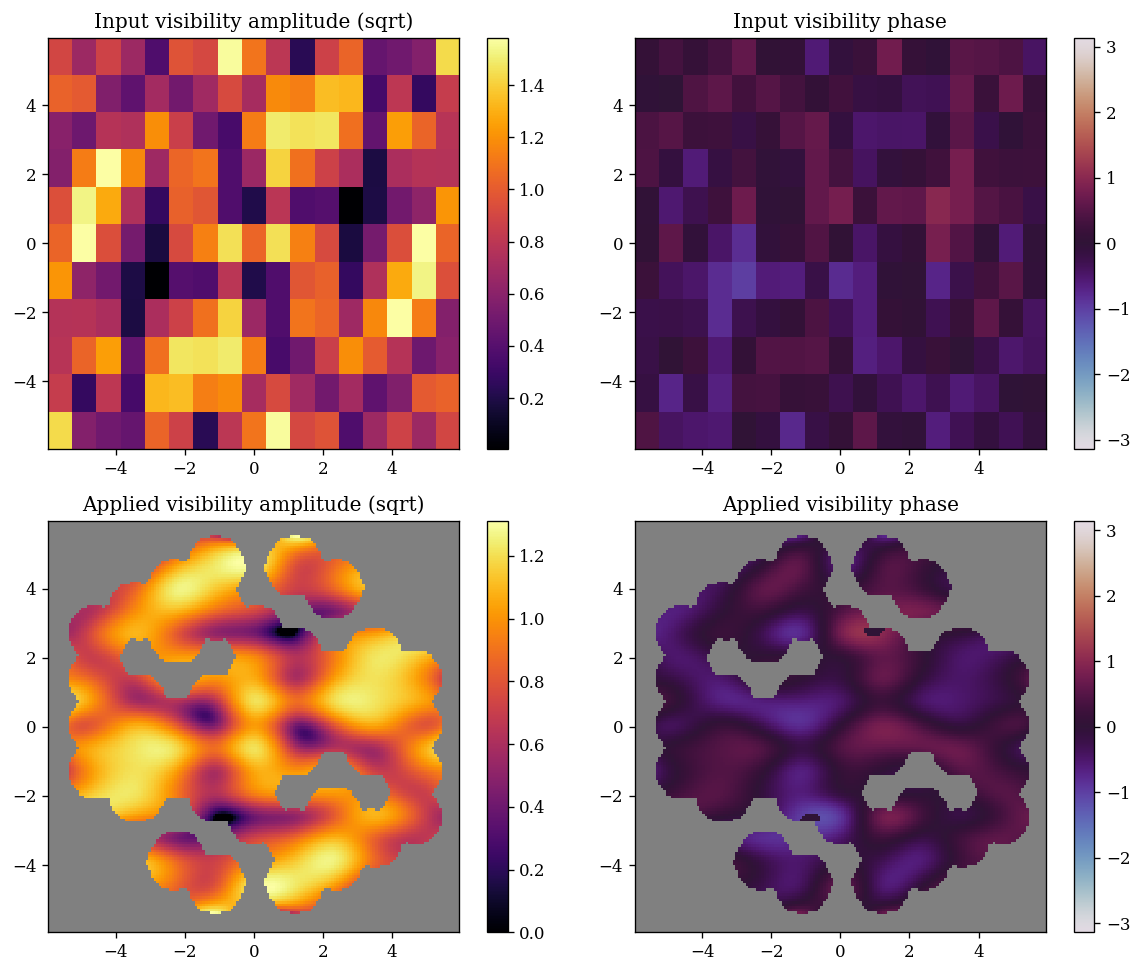

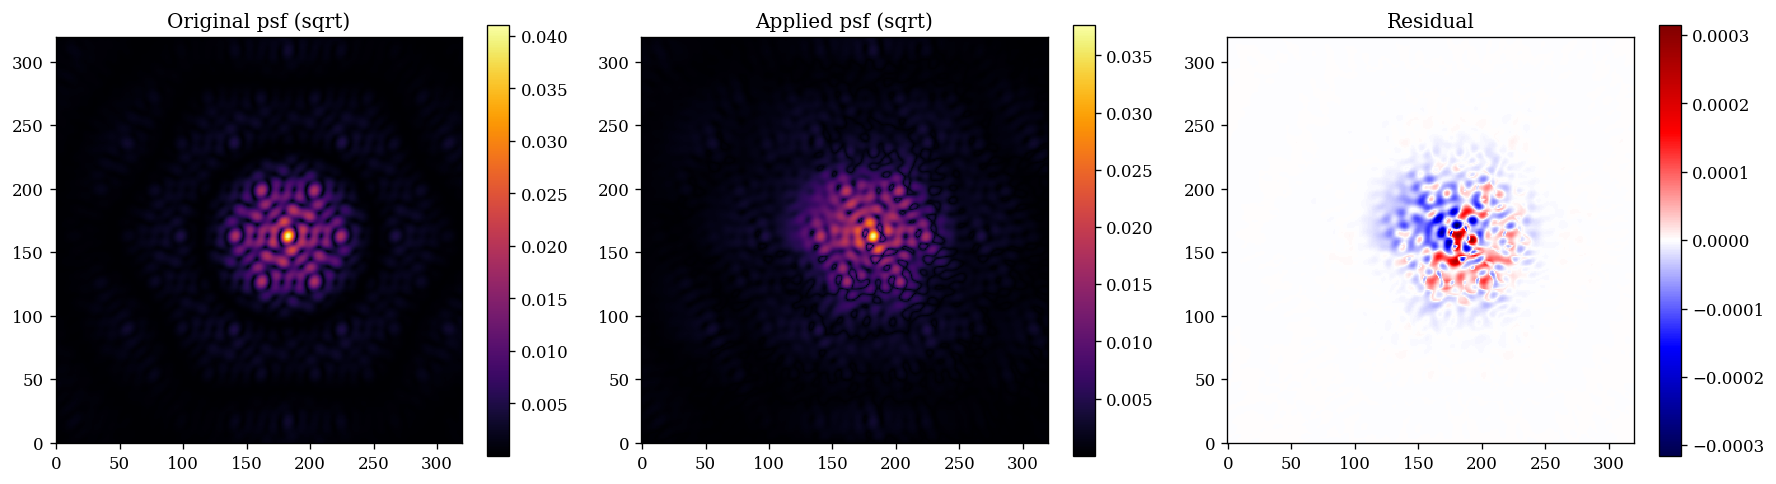

In [7]:
# Smoothing gaussian
def gaussian(sigma, nx, ny):
    xs, ys = np.linspace(-1, 1, nx), np.linspace(-1, 1, ny)
    y, x = np.meshgrid(xs, ys)
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))

kern = gaussian(0.2, 7, 7)
kern /= kern.sum()
uv_coords = np.meshgrid(u_coords, u_coords)

# Get vis amplitude values
sigma = 0.75 # Random normal sigma
amp_points = 1 + sigma * jr.normal(jr.PRNGKey(2), (nx + 4, ny + 4))
convd_amp = jax.scipy.signal.convolve(amp_points, kern, mode="same")[2:-2, 2:-2]
convd_amp = np.maximum(convd_amp, 1e-6)

# Get vis phase values
pha_points = sigma * jr.normal(jr.PRNGKey(2), (nx + 4, ny + 4))
convd_pha = jax.scipy.signal.convolve(pha_points, kern, mode="same")[2:-2, 2:-2]

# Construct input vis map
conv_vis = convd_amp * np.exp(1j * convd_pha)
flat_conv_vis = conv_vis.reshape(-1).T

# Apply conjuagte
flat_conv_vis = flat_conv_vis.at[inv_ind[:, 1]].set(flat_conv_vis[inv_ind[:, 0]].conj())
flat_conv_vis = flat_conv_vis.at[1 + len(inv_ind) // 2].set(1 * np.exp(1j * 0))
vis_pts = flat_conv_vis.reshape(conv_vis.shape)

# Get the amplitude map
amp_interper = ipx.Interpolator2D(xs, ys, np.abs(vis_pts), method="cubic2", extrap=True)
amp_interp = lambda xs, ys: amp_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)
amp_map = np.maximum(amp_interp(*uv_coords), 0)

# Get the phase map
pha_interper = ipx.Interpolator2D(
    xs, ys, np.angle(vis_pts), method="cubic2", extrap=True
)
pha_interp = lambda xs, ys: pha_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)
phase_map = pha_interp(*uv_coords)

# Get the applied visibilities map
vis_map = amp_map * np.exp(1j * phase_map)

# Get original psf
full_psf = np.abs(from_uv(full_splodges * dlu.resize(vis_map, padded.shape[0])))
applied_psf = dlu.resize(full_psf, psf.shape[0])


plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.title("Input visibility amplitude (sqrt)")
plt.imshow(np.abs(vis_pts), extent=(-ext, ext, -ext, ext))
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title("Input visibility phase")
plt.imshow(
    np.angle(vis_pts),
    cmap=twilight,
    vmin=-np.pi,
    vmax=np.pi,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("Applied visibility amplitude (sqrt)")
plt.imshow(
    np.where(mask, np.abs(vis_map), np.nan) ** 0.5,
    cmap=inferno,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("Applied visibility phase")
plt.imshow(
    np.where(mask, np.angle(vis_map), np.nan),
    cmap=twilight,
    vmin=-np.pi,
    vmax=np.pi,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))


plt.subplot(1, 3, 1)
plt.title("Original psf (sqrt)")
plt.imshow(psf**0.5, cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Applied psf (sqrt)")
plt.imshow(applied_psf**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
res = psf - applied_psf
v = np.abs(res).max()
plt.imshow(res, cmap=seismic, vmin=-v, vmax=v)
plt.colorbar()

plt.tight_layout()
plt.show()